## Your first Edward program

Probabilistic modeling in Edward uses a simple language of random variables. Here we will show a Bayesian neural network: a neural network with a prior distribution on its weights. 

This examples follow both the [getting started](http://edwardlib.org/getting-started) help on the Edward website as well the source code [here](https://github.com/blei-lab/edward/blob/master/examples/getting_started_example.py).

Let's set up our imports.

In [1]:
%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal
from edward.stats import norm

plt.style.use('ggplot')

Let's define some methods which we'll use.

`build_toy_dataset` simulates a toy dataset of 50 observations with a cosine relationship.

In [2]:
def build_toy_dataset(N=50, noise_std=0.1):
  x = np.linspace(-3, 3, num=N)
  y = np.cos(x) + norm.rvs(0, noise_std, size=N)
  x = x.reshape((N, 1))
  return x, y

Next, define a two-layer Bayesian neural network. Here, we define the neural network manually with tanh nonlinearities.

In [3]:
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

Following are sample functions from variational model to visualize fits.

In [4]:
def vis(label, message, output=False):
    
    # if our model has been setup, and output is true, we set it up for plotting
    if output:
        rs = np.random.RandomState(0)
        inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
        x = tf.expand_dims(tf.constant(inputs), 1)
        mus = []
        for s in range(10):
            mus += [neural_network(x, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample())]

        mus = tf.pack(mus)
        outputs = mus.eval()

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title(message)
    ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
    
    # again, if output is ready then we plot it
    if output:
        ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
        ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
        ax.plot(inputs, 'r', lw=2, alpha=0.5)
        
    ax.set_xlim([-5, 5])
    ax.set_ylim([-3, 3])
    ax.legend()
    plt.show()

We've our imports and helper functions set up and can start with our first Edward program!

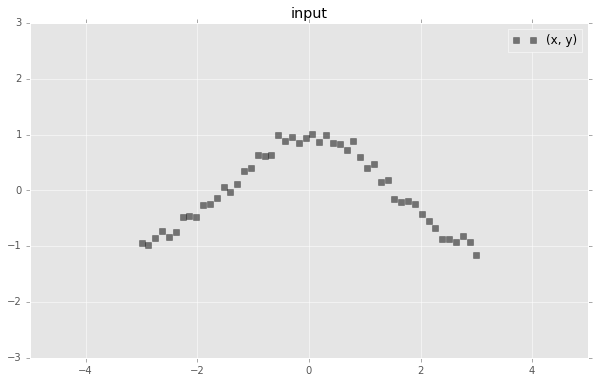

In [5]:
ed.set_seed(42)

N = 50  # num data ponts
D = 1   # num features

# DATA
x_train, y_train = build_toy_dataset(N)
vis(None, message="input")

In [6]:
# MODEL
W_0 = Normal(mu=tf.zeros([D, 2]), sigma=tf.ones([D, 2]))
W_1 = Normal(mu=tf.zeros([2, 1]), sigma=tf.ones([2, 1]))
b_0 = Normal(mu=tf.zeros(2), sigma=tf.ones(2))
b_1 = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = tf.convert_to_tensor(x_train, dtype=tf.float32)
y = Normal(mu=neural_network(x, W_0, W_1, b_0, b_1),
           sigma=0.1 * tf.ones(N))

Next, make inferences about the model from data. Edward focuses on variational inference. Specify a normal approximation over the weights and biases.

In [7]:
# INFERENCE

qW_0 = Normal(mu=tf.Variable(tf.random_normal([1, 2])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1, 2]))))
qW_1 = Normal(mu=tf.Variable(tf.random_normal([2, 1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([2, 1]))))
qb_0 = Normal(mu=tf.Variable(tf.random_normal([2])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))
qb_1 = Normal(mu=tf.Variable(tf.random_normal([1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Defining `tf.Variable` allows the variational factors’ parameters to vary. They are initialized randomly. The standard deviation parameters are constrained to be greater than zero according to a softplus transformation.

Let's set up our inference, now.

In [8]:
data = {y: y_train}
inference = ed.MFVI({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data)
inference.initialize()

Let's now visualise how our output looks without any training!

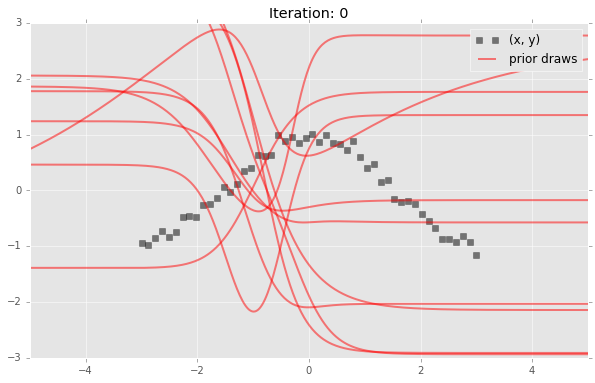

In [9]:
vis(label="prior draws", message="Iteration: 0", output=True)

Now, run mean-field variational inference. Infer the model’s latent variables conditional on data using the variational distribution. We specify 1000 iterations.

In [10]:
inference.run(n_iter=1000, n_samples=5, n_print=100)

iter 1 loss -16729.97
mu: 
[-0.32462388]
sigma: 
[ 0.49490097]
mu: 
[ 0.68616414  0.6665169 ]
sigma: 
[ 0.50215405  1.03629732]
mu: 
[[-0.43103942 -1.11911523]]
sigma: 
[[ 2.05765033  2.12485027]]
mu: 
[[-1.64068389]
 [-0.50823855]]
sigma: 
[[ 0.93492365]
 [ 0.39246175]]
iter 100 loss -1125.20
mu: 
[-0.04179848]
sigma: 
[ 0.05312504]
mu: 
[-0.40126163 -0.12528299]
sigma: 
[ 0.31098446  1.56179678]
mu: 
[[-0.31426886 -0.34910116]]
sigma: 
[[ 0.56804121  2.13648152]]
mu: 
[[-0.12007821]
 [-0.00399251]]
sigma: 
[[ 0.12660985]
 [ 0.06921478]]
iter 200 loss -1062.35
mu: 
[-0.22752784]
sigma: 
[ 0.03694153]
mu: 
[-1.42757893 -0.25690243]
sigma: 
[ 0.21520896  1.43704998]
mu: 
[[-0.3611553 -0.2477195]]
sigma: 
[[ 0.82539427  1.85968149]]
mu: 
[[-0.3800514 ]
 [ 0.04842984]]
sigma: 
[[ 0.0794761 ]
 [ 0.04636906]]
iter 300 loss -1031.53
mu: 
[-0.26092014]
sigma: 
[ 0.0287389]
mu: 
[-1.95845616 -1.0105989 ]
sigma: 
[ 0.16730517  0.94181627]
mu: 
[[-0.21514383 -0.15412213]]
sigma: 
[[ 1.23362374  

Finally, criticize the model fit. Bayesian neural networks define a distribution over neural networks, so let’s do a graphical check. Draw neural networks from the inferred model and visualize how well it fits the data.

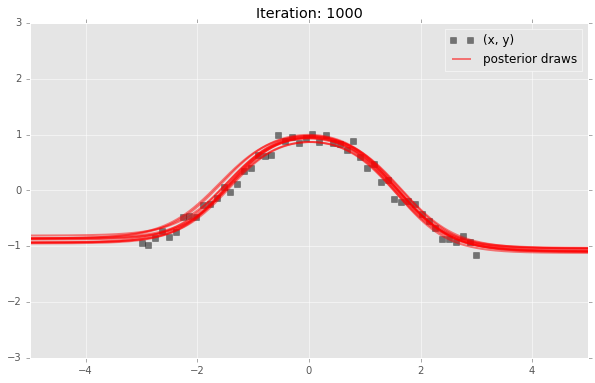

In [11]:
vis(label="posterior draws", message="Iteration: 1000", output=True)

As you can see, the model has learned the cosine relationship between x and y.